(None, 784) 128
(None, 128) 10
Epoch 1/20
1875/1875 [==============================] - 6s 3ms/step - loss: 1.1588 - accuracy: 0.8798 - val_loss: 0.2909 - val_accuracy: 0.9199
Epoch 2/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2662 - accuracy: 0.9308 - val_loss: 0.2999 - val_accuracy: 0.9318
Epoch 3/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2522 - accuracy: 0.9365 - val_loss: 0.2397 - val_accuracy: 0.9426
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2319 - accuracy: 0.9440 - val_loss: 0.2782 - val_accuracy: 0.9393
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2222 - accuracy: 0.9480 - val_loss: 0.3255 - val_accuracy: 0.9283
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2019 - accuracy: 0.9527 - val_loss: 0.2779 - val_accuracy: 0.9475
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2023 - accuracy: 0.9520 - v

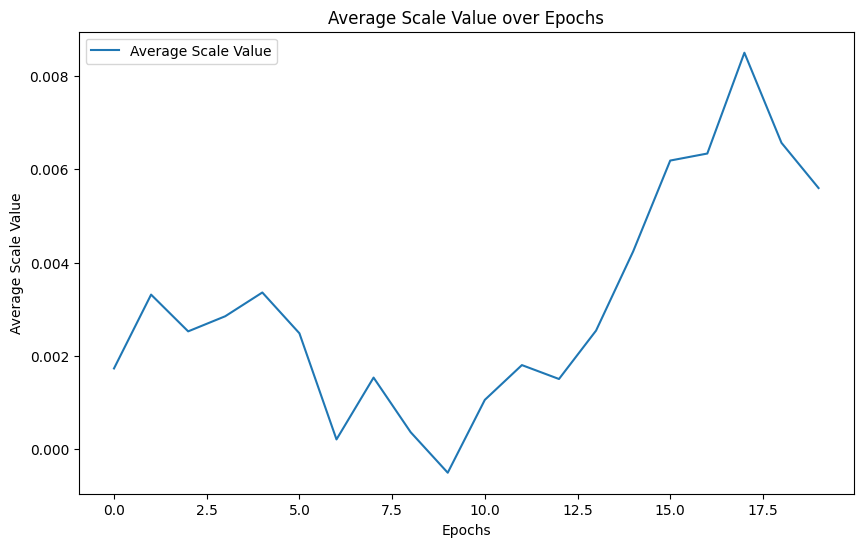

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        scale_value = np.mean(self.layer.scale.numpy())
        self.average_scale_values.append(scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {scale_value}")

    def plot_average_scale_values(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.average_scale_values, label='Average Scale Value')
        plt.xlabel('Epochs')
        plt.ylabel('Average Scale Value')
        plt.title('Average Scale Value over Epochs')
        plt.legend()
        plt.show()

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Create the callback
average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(x_train, y_train, epochs=20, validation_data=(x_test, y_test), callbacks=[average_scale_tracking_callback])
loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the average scale values
average_scale_tracking_callback.plot_average_scale_values()


(None, 784) 128
(None, 128) 10
Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 1.2831 - accuracy: 0.8827 - val_loss: 0.2995 - val_accuracy: 0.9292
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2739 - accuracy: 0.9316 - val_loss: 0.2850 - val_accuracy: 0.9317
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2506 - accuracy: 0.9389 - val_loss: 0.2583 - val_accuracy: 0.9405
Epoch 4/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2425 - accuracy: 0.9429 - val_loss: 0.2748 - val_accuracy: 0.9425
Epoch 5/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2384 - accuracy: 0.9449 - val_loss: 0.3088 - val_accuracy: 0.9389
Epoch 6/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2235 - accuracy: 0.9481 - val_loss: 0.2752 - val_accuracy: 0.9464
Epoch 7/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.2172 - accuracy: 0.9514 - v

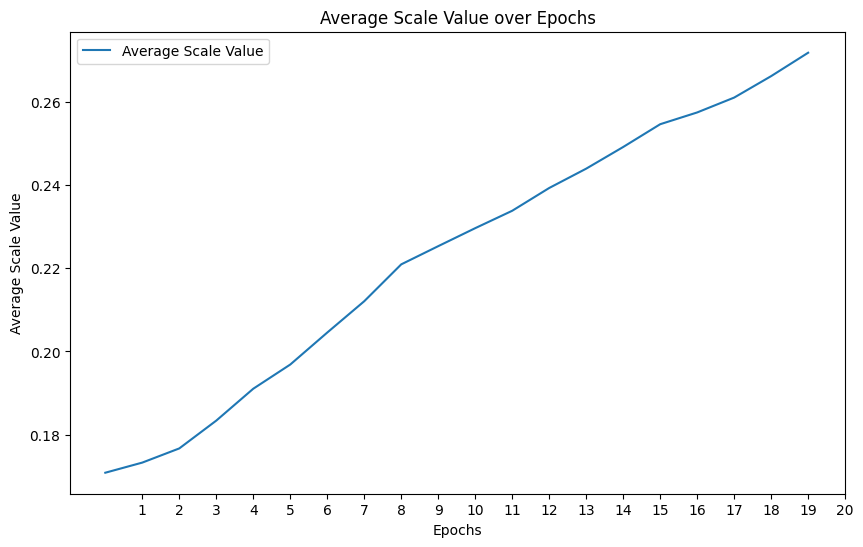

In [17]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        scale_value = np.mean(self.layer.scale.numpy())
        self.average_scale_values.append(scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {scale_value}")

    def plot_average_scale_values(self):
        plt.figure(figsize=(10, 6))
        plt.plot(self.average_scale_values, label='Average Scale Value')
        plt.xlabel('Epochs')
        plt.ylabel('Average Scale Value')
        plt.title('Average Scale Value over Epochs')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()
        plt.show()

def custom_loss(y_true, y_pred, scale):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    scale_regularization = tf.reduce_mean(tf.maximum(0.0, 1.0 - scale))  
    return cross_entropy_loss + 0.01 * scale_regularization  # Adjust the regularization weight as needed

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, quantized_dense_layer.scale),
    metrics=['accuracy']
)

average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[average_scale_tracking_callback]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the average scale values
average_scale_tracking_callback.plot_average_scale_values()


(None, 784) 128
(None, 128) 10
Epoch 1/20
1857/1875 [============================>.] - ETA: 0s - loss: 94.6415 - accuracy: 0.8644
Shape of scale:  (784, 1) 

Epoch 1: Average scale value: 0.1776529848575592
1875/1875 [==============================] - 5s 2ms/step - loss: 94.3933 - accuracy: 0.8648 - val_loss: 68.5888 - val_accuracy: 0.9208
Epoch 2/20
1860/1875 [============================>.] - ETA: 0s - loss: 57.1824 - accuracy: 0.9242
Shape of scale:  (784, 1) 

Epoch 2: Average scale value: 0.2816700339317322
1875/1875 [==============================] - 5s 2ms/step - loss: 57.1092 - accuracy: 0.9242 - val_loss: 47.9953 - val_accuracy: 0.9258
Epoch 3/20
1871/1875 [============================>.] - ETA: 0s - loss: 41.4873 - accuracy: 0.9360
Shape of scale:  (784, 1) 

Epoch 3: Average scale value: 0.39418551325798035
1875/1875 [==============================] - 4s 2ms/step - loss: 41.4756 - accuracy: 0.9359 - val_loss: 35.8474 - val_accuracy: 0.9337
Epoch 4/20
1857/1875 [=============

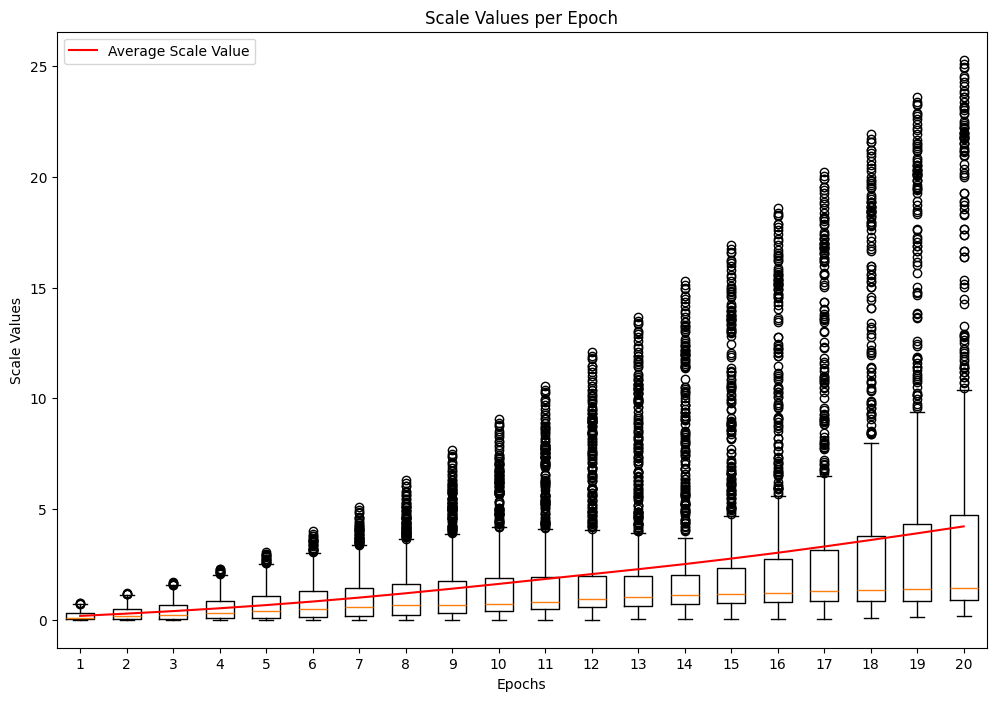

In [41]:
# With box plots and 
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') 
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)


class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        print(input_shape, self.units)
        self.w = self.add_weight(           shape=(input_shape[-1], self.units), 
                                            initializer="random_normal",
                                            trainable=True)
        self.b = self.add_weight(           shape=(self.units,), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.scale = self.add_weight(       shape=(input_shape[-1], 1), 
                                            initializer="random_normal", 
                                            trainable=True)
        self.zero_point = self.add_weight(  shape=(input_shape[-1], 1), 
                                            initializer="random_normal",
                                            trainable=True)


    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        print("\nShape of scale: ", self.layer.scale.shape, "\n")
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {average_scale_value}")

    def plot_scale_values(self):
        plt.figure(figsize=(12, 8))

        # Create the box plot
        plt.boxplot(self.scale_values_per_epoch, positions=range(1, len(self.scale_values_per_epoch) + 1), widths=0.6)

        # Plot the average scale values
        plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red')

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()
        plt.show()


def custom_loss(y_true, y_pred, scale):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    scale_penalty = tf.reduce_mean(1.0 / (scale + 1e-6))  # Add a small epsilon to avoid division by zero
    return cross_entropy_loss + 1 * scale_penalty  # Adjust the regularization weight as needed

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, quantized_dense_layer.scale),
    metrics=['accuracy']
)

average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[average_scale_tracking_callback]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the average scale values
average_scale_tracking_callback.plot_scale_values()


Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 25.2243 - accuracy: 0.8626 - val_loss: 17.3309 - val_accuracy: 0.9136
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 14.4314 - accuracy: 0.9206 - val_loss: 12.1242 - val_accuracy: 0.9299
Epoch 3/20
1875/1875 [==============================] - 5s 2ms/step - loss: 10.5078 - accuracy: 0.9316 - val_loss: 9.1270 - val_accuracy: 0.9343
Epoch 4/20
1875/1875 [==============================] - 5s 2ms/step - loss: 7.9889 - accuracy: 0.9377 - val_loss: 6.9811 - val_accuracy: 0.9394
Epoch 5/20
1875/1875 [==============================] - 5s 3ms/step - loss: 6.1653 - accuracy: 0.9401 - val_loss: 5.4251 - val_accuracy: 0.9454
Epoch 6/20
1875/1875 [==============================] - 5s 2ms/step - loss: 4.7797 - accuracy: 0.9427 - val_loss: 4.2290 - val_accuracy: 0.9452
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 3.7470 - accuracy: 0.9425 - val_loss: 3.3893 - val_accu

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_913/4291955861.py:69: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


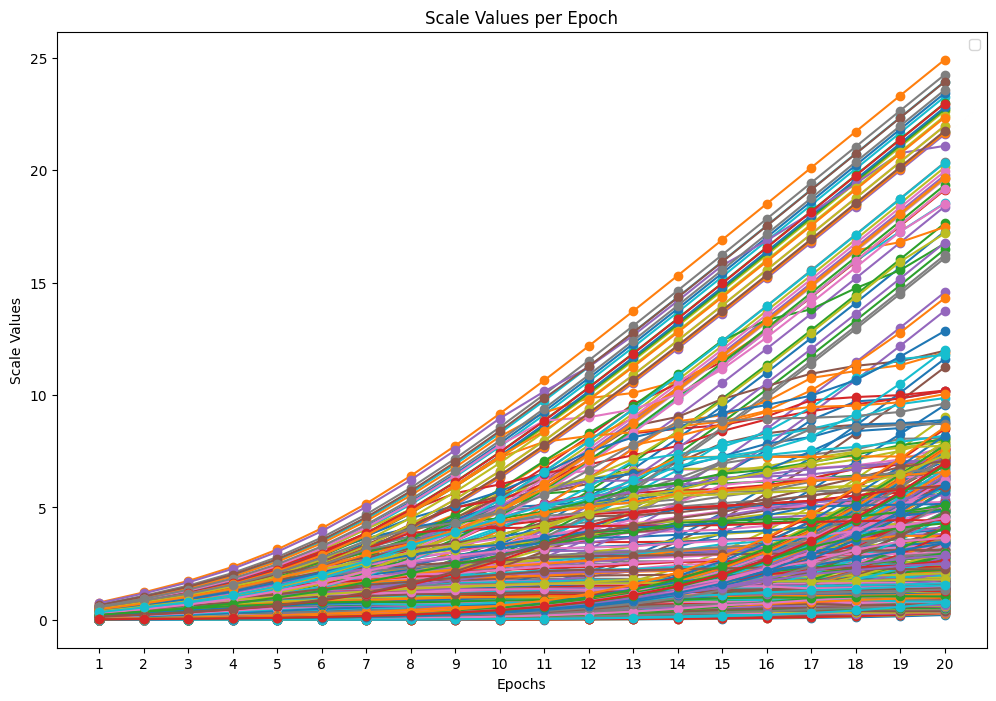

In [44]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.zero_point = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        print(f"Epoch {epoch+1}: Average scale value: {average_scale_value}")

    def plot_scale_values(self):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()
        plt.show()

def custom_loss(y_true, y_pred, scale):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    scale_penalty = tf.reduce_mean(1.0 / (scale + 1e-6))  # Add a small epsilon to avoid division by zero
    return cross_entropy_loss + 0.5 * scale_penalty  # Adjust the regularization weight as needed

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, quantized_dense_layer.scale),
    metrics=['accuracy']
)

average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[average_scale_tracking_callback]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the scale values
average_scale_tracking_callback.plot_scale_values()


Epoch 1/20
1859/1875 [============================>.] - ETA: 0s - loss: 44.5539 - accuracy: 0.8716
Epoch 1: Average scale value: 0.16093851625919342, Loss: 44.45884323120117, Accuracy: 0.8718666434288025
1875/1875 [==============================] - 5s 2ms/step - loss: 44.4588 - accuracy: 0.8719 - val_loss: 33.3005 - val_accuracy: 0.9144
Epoch 2/20
1859/1875 [============================>.] - ETA: 0s - loss: 27.6589 - accuracy: 0.9259
Epoch 2: Average scale value: 0.2539357542991638, Loss: 27.62053108215332, Accuracy: 0.9260166883468628
1875/1875 [==============================] - 5s 2ms/step - loss: 27.6205 - accuracy: 0.9260 - val_loss: 23.0674 - val_accuracy: 0.9399
Epoch 3/20
1864/1875 [============================>.] - ETA: 0s - loss: 19.9494 - accuracy: 0.9365
Epoch 3: Average scale value: 0.3546781837940216, Loss: 19.933696746826172, Accuracy: 0.9363166689872742
1875/1875 [==============================] - 4s 2ms/step - loss: 19.9337 - accuracy: 0.9363 - val_loss: 17.1548 - val_a

/var/folders/ms/xd16k27j2lj0dx3xp_nqkcgr0000gn/T/ipykernel_913/3018895885.py:73: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


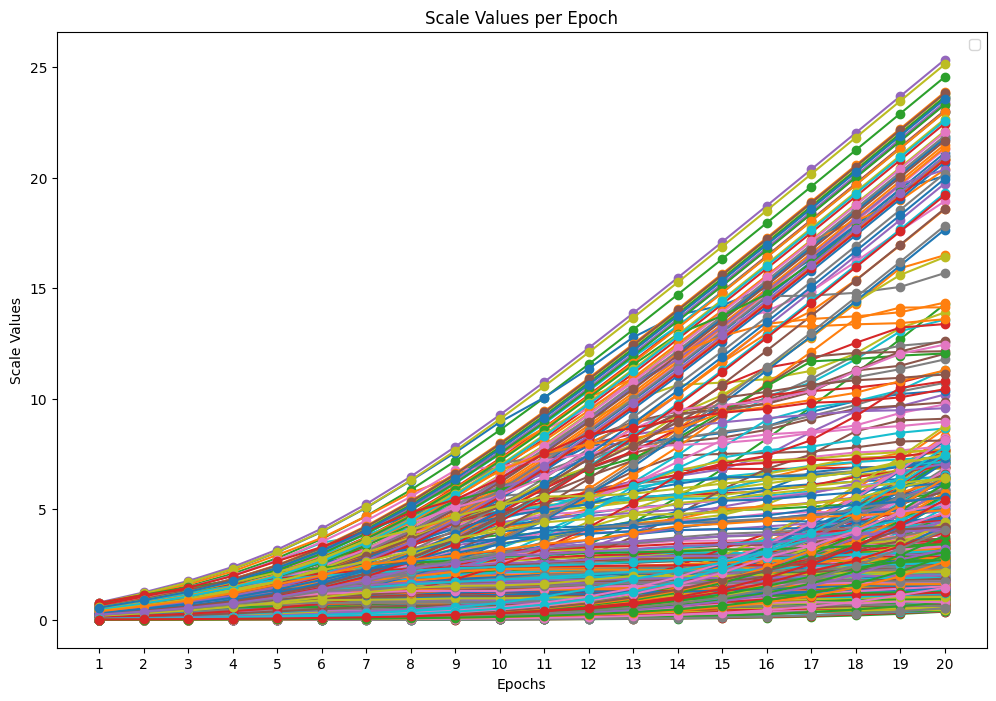

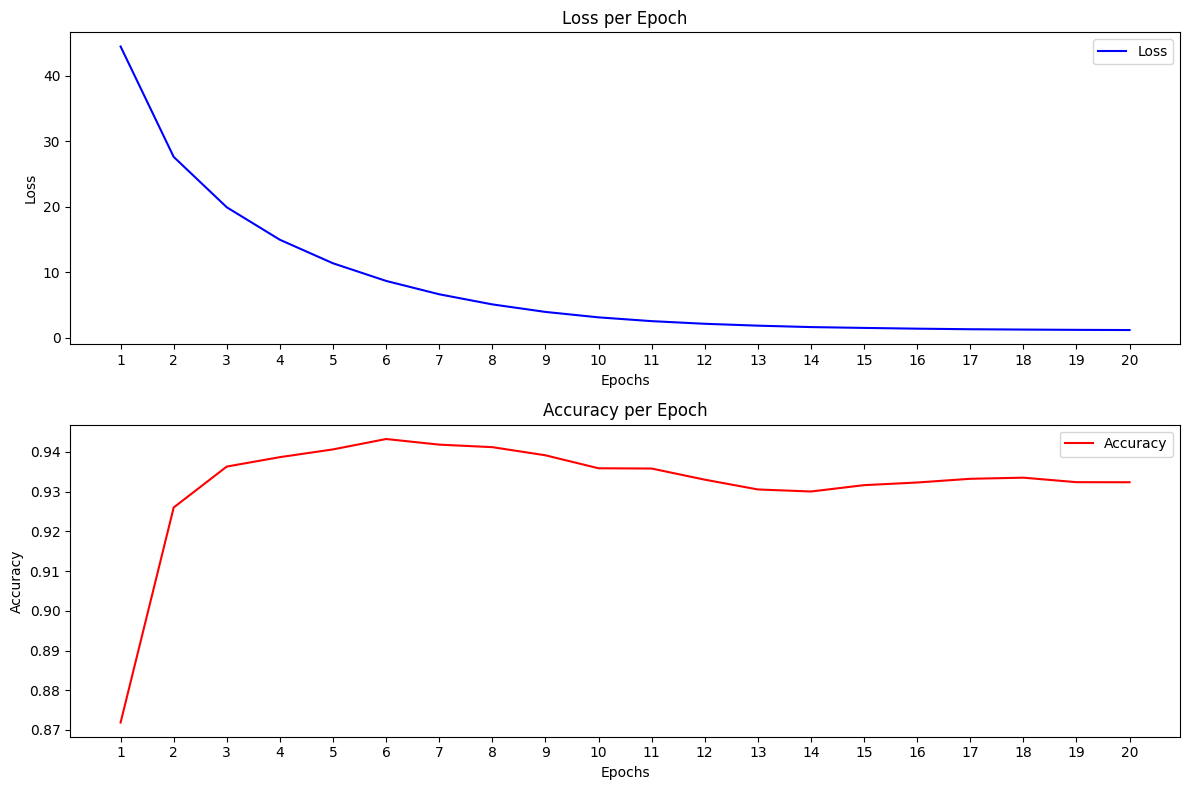

In [49]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
import numpy as np

# Prepare the data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train = np.expand_dims(x_train, -1) # CNNs typically expect input data to be 4D
x_test = np.expand_dims(x_test, -1)

class LearnedQuantizedDense(tf.keras.layers.Layer):
    def __init__(self, units, activation=None):
        super(LearnedQuantizedDense, self).__init__()
        self.units = units
        self.activation = tf.keras.activations.get(activation)

    def build(self, input_shape):
        self.w = self.add_weight(shape=(input_shape[-1], self.units), initializer="random_normal", trainable=True)
        self.b = self.add_weight(shape=(self.units,), initializer="random_normal", trainable=True)
        self.scale = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)
        self.zero_point = self.add_weight(shape=(input_shape[-1], 1), initializer="random_normal", trainable=True)

    def call(self, inputs):
        quantized_w = tf.stop_gradient(tf.round(self.w / self.scale + self.zero_point)) + \
                      (self.w / self.scale + self.zero_point - tf.stop_gradient(self.w / self.scale + self.zero_point))
        dequantized_w = (quantized_w - self.zero_point) * self.scale
        quantized_b = tf.stop_gradient(tf.round(self.b / self.scale[0, 0] + self.zero_point[0, 0])) + \
                      (self.b / self.scale[0, 0] + self.zero_point[0, 0] - tf.stop_gradient(self.b / self.scale[0, 0] + self.zero_point[0, 0]))
        dequantized_b = (quantized_b - self.zero_point[0, 0]) * self.scale[0, 0]
        
        output = tf.matmul(inputs, dequantized_w) + dequantized_b
        if self.activation is not None:
            output = self.activation(output)
        return output

class AverageScaleTrackingCallback(tf.keras.callbacks.Callback):
    def __init__(self, layer):
        super(AverageScaleTrackingCallback, self).__init__()
        self.layer = layer
        self.scale_values_per_epoch = []
        self.average_scale_values = []
        self.epoch_loss = []
        self.epoch_accuracy = []

    def on_epoch_end(self, epoch, logs=None):
        scale_values = self.layer.scale.numpy().flatten()
        self.scale_values_per_epoch.append(scale_values)
        average_scale_value = np.mean(scale_values)
        self.average_scale_values.append(average_scale_value)
        self.epoch_loss.append(logs['loss'])
        self.epoch_accuracy.append(logs['accuracy'])
        print(f"\nEpoch {epoch+1}: Average scale value: {average_scale_value}, Loss: {logs['loss']}, Accuracy: {logs['accuracy']}")

    def plot_scale_values(self):
        plt.figure(figsize=(12, 8))

        # Plot each scale value trajectory
        for i in range(len(self.scale_values_per_epoch[0])):
            scale_trajectory = [epoch[i] for epoch in self.scale_values_per_epoch]
            plt.plot(range(1, len(self.scale_values_per_epoch) + 1), scale_trajectory, linestyle='-', marker='o')

        # Plot the average scale values
        #plt.plot(range(1, len(self.average_scale_values) + 1), self.average_scale_values, label='Average Scale Value', color='red', linewidth=2)

        plt.xlabel('Epochs')
        plt.ylabel('Scale Values')
        plt.title('Scale Values per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()
        plt.show()

    def plot_loss_accuracy(self):
        epochs = range(1, len(self.epoch_loss) + 1)

        plt.figure(figsize=(12, 8))

        plt.subplot(2, 1, 1)
        plt.plot(epochs, self.epoch_loss, 'b-', label='Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Loss per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()

        plt.subplot(2, 1, 2)
        plt.plot(epochs, self.epoch_accuracy, 'r-', label='Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.title('Accuracy per Epoch')
        plt.xticks(range(1, len(self.average_scale_values) + 1))  # Set x-ticks to be integers
        plt.legend()

        plt.tight_layout()
        plt.show()

def custom_loss(y_true, y_pred, scale):
    cross_entropy_loss = tf.keras.losses.sparse_categorical_crossentropy(y_true, y_pred)
    scale_penalty = tf.reduce_mean(1.0 / (scale + 1e-6))  # Add a small epsilon to avoid division by zero
    return cross_entropy_loss + 1 * scale_penalty  # Adjust the regularization weight as needed

input_layer = Input(shape=(28, 28, 1))
flatten_layer = Flatten()(input_layer)
quantized_dense_layer = LearnedQuantizedDense(128, activation='relu')
dense_output = quantized_dense_layer(flatten_layer)
output_layer = LearnedQuantizedDense(10, activation='softmax')(dense_output)

quantized_model = Model(inputs=input_layer, outputs=output_layer)
quantized_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=lambda y_true, y_pred: custom_loss(y_true, y_pred, quantized_dense_layer.scale),
    metrics=['accuracy']
)

average_scale_tracking_callback = AverageScaleTrackingCallback(quantized_dense_layer)

quantized_model.fit(
    x_train, y_train,
    epochs=20,
    validation_data=(x_test, y_test),
    callbacks=[average_scale_tracking_callback]
)

loss, accuracy = quantized_model.evaluate(x_test, y_test)
print(f'Quantized Model Test Accuracy: {accuracy}')

# Plot the scale values
average_scale_tracking_callback.plot_scale_values()
average_scale_tracking_callback.plot_loss_accuracy()
